### Import and Clean the Data

In [2]:
import pandas as pd
from collections import defaultdict
import datetime
from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns
import numpy as np
from sklearn import linear_model
% matplotlib inline

df = pd.read_csv('Iowa_Liquor_Sales_reduced.csv')

/Users/codylaminack/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['Date']=pd.to_datetime(df['Date'], infer_datetime_format=True)


#Drop the Dollar sign from columns and convert the remaining values to floats

df['State Bottle Cost'].replace(to_replace='\$', value='', inplace=True, regex=True)
df['State Bottle Cost']=df['State Bottle Cost'].astype(float)


df['State Bottle Retail'].replace(to_replace='\$', value='', inplace=True, regex=True)
df['State Bottle Retail']=df['State Bottle Retail'].astype(float)



df['Sale (Dollars)'].replace(to_replace='\$', value='', inplace=True, regex=True)
df['Sale (Dollars)']=df['Sale (Dollars)'].astype(float)

In [4]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()
# What's the largest bottle sold?
df.ix[[df['Bottle Volume (ml)'].argmax()]]
# How many unique categories are there? 
df['Category Name'].nunique()

73

In [5]:
# How many stores are there? 
df['Store Number'].nunique()

1403

In [6]:
# There are two sales that have a bottle volume of 0 ml. Unless this is ghost
# vodka, there was an error somewhere. After doing research, I'd like to replace them
# with what probably should be there. Based on research, that should be 100ml.
df[df['Bottle Volume (ml)']==0]
df[df['Bottle Volume (ml)']==0] = 100

In [7]:
#Rename the columns to make them easier to work with from here on out
df.rename(columns={'Store Number': 'store', 'Zip Code':'zip', 'County Number':'county',
        'Category Name':'category', 'Vendor Number':'vendor', 'Item Number':'item',
        'Bottle Volume (ml)':'mls','State Bottle Cost':'state_cost', 'State Bottle Retail':'state_retail',
        'Bottles Sold':'bottles_sold','Sale (Dollars)':'sale', 'Volume Sold (Liters)':'liters_sold'}, inplace=True)
#There isn't a column that had the toal sale in it. There's a column for 'Sale (Dollars)'
# that isn't especially useful. It should be renamed to be simpler, and then its values should be replaced
# with

In [8]:
#Create a column for margins
df['margin'] = (df['sale']) - (df['state_cost']*df['bottles_sold'])


#Create a price per liter column

df['ppl']=(df['state_retail']/df['mls'])*1000

In [91]:
df.sale.describe()

count   2709552.00
mean        129.12
std         399.46
min           1.34
25%          30.48
50%          70.56
75%         135.00
max      106326.00
Name: sale, dtype: float64

In [9]:
# Create a mask that only contains the 2015 sales. Building a model off this will allow us to model 2016 sales.
start_date = pd.Timestamp('20150101')
end_date = pd.Timestamp('20151231')
mask = (df['Date'] >= start_date) & (df['Date']<=end_date)
sales=df[mask]
sales.head()
sales.shape

(2184481, 20)

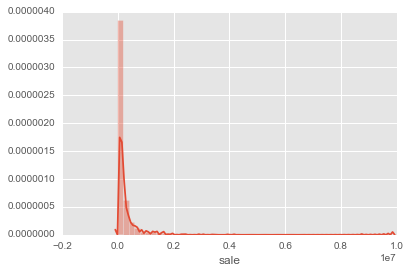

In [90]:
# This little number gives you each store's sales broken down by category.

sales.groupby('store').category.value_counts()
# This distribution shows that the sales data has an incredibly long tail. Most of the data is clustered to the left of
# the distribution. 
sns.distplot(sales.groupby('store').sale.sum())
plt.show()
plt.savefig('salesdistribution.png')

In [85]:
stores = sales.groupby(by=['store'], as_index=False)
sales2 = sales.groupby(by=['store'], as_index=False)

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [12]:
stores = stores.agg({"sale": [np.sum, np.mean, np.count_nonzero],
                   "liters_sold": [np.sum, np.mean],
                   "margin": np.mean,
                   "ppl": np.mean,
                   "zip": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "county": lambda x: x.iloc[0],
                   "Date": (np.min, np.max)})

In [13]:
stores.columns = ['_'.join(col).strip() for col in stores.columns.values]

Index([u'store_', u'county_<lambda>', u'City_<lambda>', u'zip_<lambda>',
       u'Date_amin', u'Date_amax', u'liters_sold_sum', u'liters_sold_mean',
       u'margin_mean', u'sale_sum', u'sale_mean', u'sale_count_nonzero',
       u'ppl_mean'],
      dtype='object')

In [14]:
# Examine the first few rows of this grouped database.
stores.head()

,store_,county_<lambda>,City_<lambda>,zip_<lambda>,Date_amin,Date_amax,liters_sold_sum,liters_sold_mean,margin_mean,sale_sum,sale_mean,sale_count_nonzero,ppl_mean
0,2106,7.00,CEDAR FALLS,50613,2015-01-08,2015-12-30,93986.47,18.41,93.77,1434369.85,280.97,5105.00,18.89
1,2113,94.00,GOWRIE,50543,2015-01-07,2015-12-29,6500.83,4.78,21.08,85763.42,63.02,1361.00,17.62
2,2130,7.00,WATERLOO,50703,2015-01-08,2015-12-30,65562.88,16.60,93.61,1108184.99,280.62,3949.00,17.51
3,2152,17.00,ROCKWELL,50469,2015-01-08,2015-12-30,6164.92,4.30,16.82,72080.36,50.23,1435.00,13.04
4,2178,3.00,WAUKON,52172,2015-01-07,2015-12-29,21719.49,8.16,35.01,277987.96,104.39,2663.00,16.60


In [15]:
start_date = pd.Timestamp('20150101')
end_date = pd.Timestamp('20150331')
q1 = (df['Date'] >= start_date) & (df['Date']<=end_date)
q1=df[q1]
q1 = q1.groupby(by=['store'], as_index=False)
q1 = q1.agg({"sale": [np.sum, np.mean, np.count_nonzero],
                   "liters_sold": [np.sum, np.mean],
                   "margin": np.mean,
                   "ppl": np.mean,
                   "zip": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "county": lambda x: x.iloc[0],
                   "Date": (np.min, np.max)})
q1.columns = ['_'.join(col).strip() for col in q1.columns.values]
# The q2 actually has nothing to do with quarter two. For ease of merging, I created a new dataframe that consists
# only of the store number and the sales from quarter one. This will be joined onto the total database.
q2 = q1[['store_', 'sale_sum']]


,store_,sale_sum
0,2106,337166.53
1,2113,22351.86
2,2130,277764.46
3,2152,16805.11
4,2178,54411.42
5,2190,255939.81
6,2191,319020.69
7,2200,45340.33
8,2205,57849.23
9,2228,51031.04


#### First Quarter Sales Vs. Yearly Sales

As can be seen below, there is a strong correlation between yearly sales and first quarter sales. This relationship will be useful when modeling.

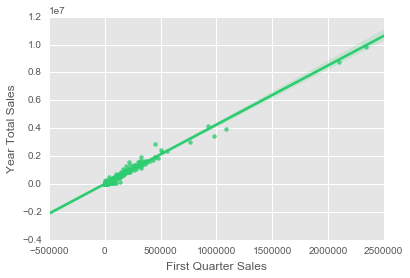

In [96]:
# This merged dataframe has both yearly sales totals as well as sales for quarter 1. The problem is that
# some stores weren't open during q1. We need to figure out a way to remove those. Or fill them with an appropriate value.
merged = pd.merge(stores, q2, on='store_', how='left')

merged = merged[merged['sale_sum_y']>=0]
sns.regplot(x='sale_sum_y', y='sale_sum_x', data=merged, color='#2ecc71')
sns.axlabel(xlabel='First Quarter Sales', ylabel='Year Total Sales')

Index([u'Date', u'store', u'City', u'zip', u'county', u'County', u'Category',
       u'category', u'vendor', u'item', u'Item Description', u'mls',
       u'state_cost', u'state_retail', u'bottles_sold', u'sale',
       u'liters_sold', u'Volume Sold (Gallons)', u'margin', u'ppl'],
      dtype='object')

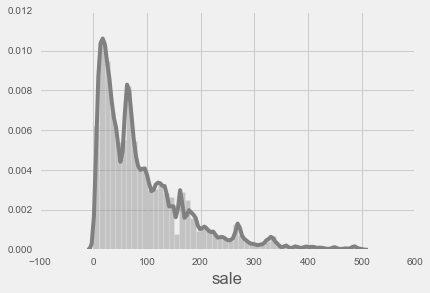

In [97]:
#Start making some graphs to pick out correlations.
plt.style.use('fivethirtyeight')
# There's a super long tail on the sales data. Some of the stores have a really high 
# average sale.
sns.distplot(df[df.sale <= 500].sale, color='grey')
sales.columns

#### Pair Plotting

These pair plots, show the relationships between some of the variables in the overall sales column (not very useful), and in our dataframe grouped by stores (more useful). These will help guide our modeling while picking out contributing variables.

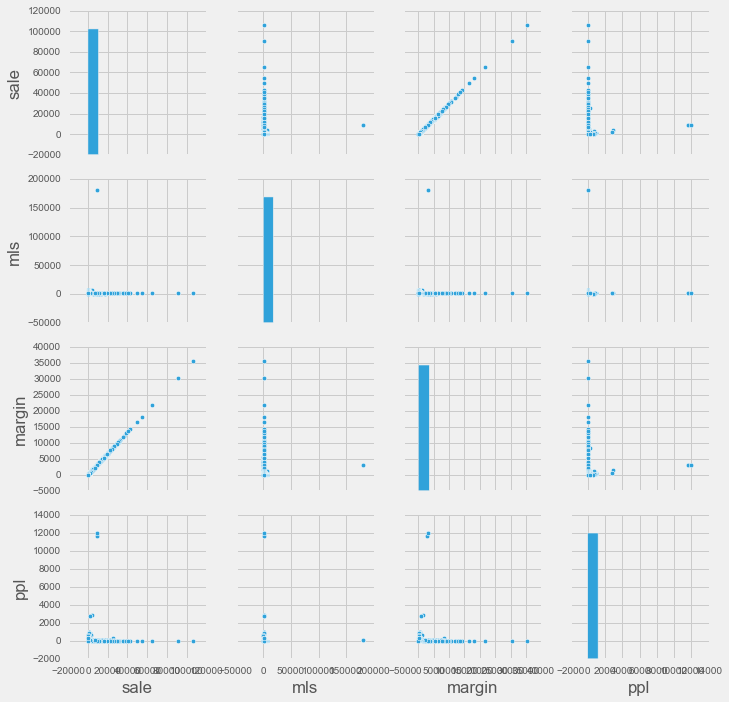

In [98]:
sns.pairplot(x_vars=['sale', 'mls', 'margin', 'ppl'],
                        y_vars=['sale', 'mls', 'margin', 'ppl'],
                        data = sales)

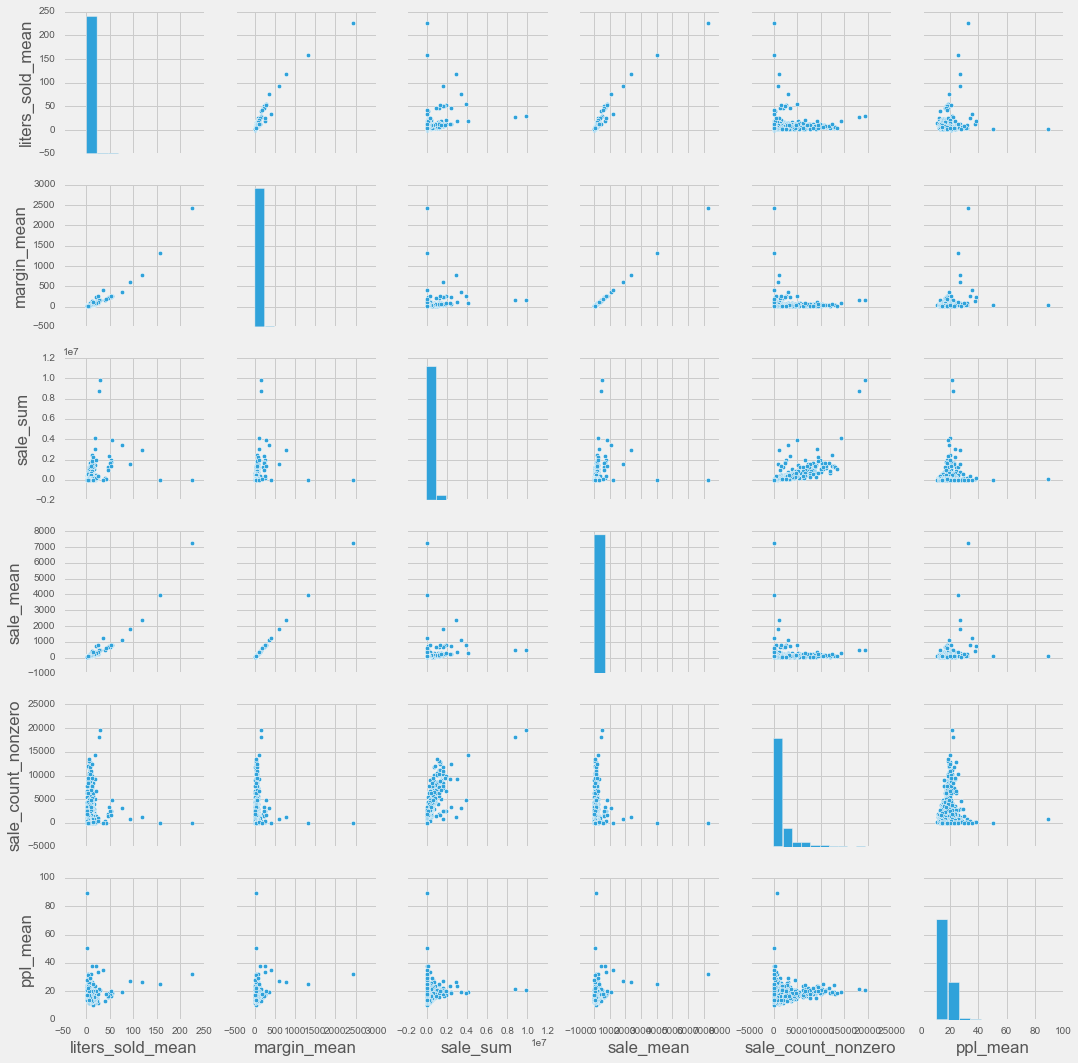

In [99]:
sns.pairplot(x_vars = ['liters_sold_mean', 'margin_mean', 'sale_sum', 'sale_mean', 'sale_count_nonzero',
                      'ppl_mean'], y_vars =['liters_sold_mean', 'margin_mean', 'sale_sum', 'sale_mean', 'sale_count_nonzero',
                      'ppl_mean'], data = stores)

In [100]:
# Create a data frame for first quarter sales in 2015. This will give us a baseline for our model.
start_date = pd.Timestamp('20150101')
end_date = pd.Timestamp('20150331')
q1 = (df['Date'] >= start_date) & (df['Date']<=end_date)
q1=df[q1]
q1 = q1.groupby(by=['store'], as_index=False)
q1 = q1.agg({"sale": [np.sum, np.mean, np.count_nonzero],
                   "liters_sold": [np.sum, np.mean],
                   "margin": np.mean,
                   "ppl": np.mean,
                   "zip": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "county": lambda x: x.iloc[0],
                   "Date": (np.min, np.max)})
q1.columns = ['_'.join(col).strip() for col in q1.columns.values]

In [101]:
from sklearn.metrics import r2_score

R^2 Score:  0.985149583078
2015 Actual Sales:  54382585.92
2015 Test set Prediction:  54785070.147


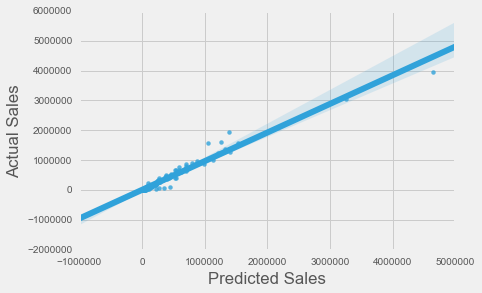

In [107]:
# This model charts the relationships between total sales for the year and the factors listed in the X array, including
# first quarter sales
# This will give us a model that we can test against total sales for 2016.
# This model appears to be really overfit. I'm concerned about the accuracy, but this seems more about process
# than the actual results. 
from sklearn.cross_validation import train_test_split
lmr = linear_model.RidgeCV()
X=merged[['liters_sold_mean', 'ppl_mean', 'sale_sum_y', 'margin_mean']]
y=merged['sale_sum_x']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = lmr.fit(X_train,y_train)
prediction = lmr.predict(X_test)
sns.regplot(x=prediction, y=y_test)
sns.axlabel(xlabel='Predicted Sales', ylabel='Actual Sales')
print 'R^2 Score: ',lmr.score(X_train,y_train)
print '2015 Actual Sales: ',y_test.sum()
print '2015 Test set Prediction: ', prediction.sum() 

Cross-validated scores: [ 0.96236496  0.97720139  0.95618821  0.94242282  0.96474164  0.95233747
  0.94740275  0.95733936  0.86234851  0.99863463  0.92797041 -0.12412542]
Cross-Predicted Accuracy: 0.966100523354


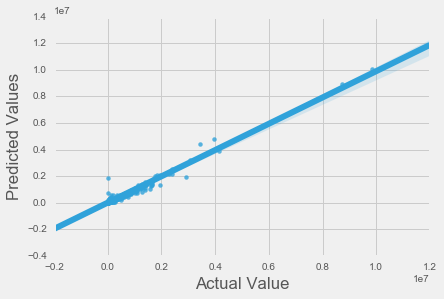

In [108]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
scores = cross_val_score(model, X, y, cv=12)
print "Cross-validated scores:", scores
predictions = cross_val_predict(model, X, y, cv=12)
sns.regplot(x=y, y=predictions)
sns.axlabel(xlabel='Actual Value', ylabel='Predicted Values')
accuracy = metrics.r2_score(y, predictions)
print "Cross-Predicted Accuracy:", accuracy

In [109]:
#Creating a mask for 2016 data. We'll use this dataframe to predict the rest of 2016's sales. This also becomes like our final 
# test data.
start_date = pd.Timestamp('20160101')
end_date = pd.Timestamp('20160331')
mask2016 = (df['Date'] >= start_date) & (df['Date']<=end_date)
futuresales=df[mask2016]
futuresales.shape
futuresales = futuresales.groupby(by=['store'], as_index=False)
futuresales = futuresales.agg({"sale": [np.sum, np.mean, np.count_nonzero],
                   "liters_sold": [np.sum, np.mean],
                   "margin": np.mean,
                   "ppl": np.mean,
                   "zip": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "county": lambda x: x.iloc[0],
                   "Date": (np.min, np.max)})

In [110]:
futuresales.columns = ['_'.join(col).strip() for col in futuresales.columns.values]

In [111]:
#I might be incredibly wrong, but this seems to suggest that the projected sales for 2016 are printed below
# How does our model fit 2016 sales
#This is the data that we'll be feeding into our model, which will give us an array of store sales totals
# We can sum that array in order to get projected sales for the year.
X3=futuresales[['liters_sold_mean', 'ppl_mean', 'sale_sum', 'margin_mean']]

prediction = lmr.predict(X3)


# The model fits the sales okay. 
print '2015 actual sales', y.sum()
print '2016 predicted sales: ', prediction.sum()
print 'Increase in sales of ', prediction.sum()-y.sum()
print 'That represents a %.2f percent increase.' %((prediction.sum()-y.sum())/y.sum()*100)

2015 actual sales 278340122.18
2016 predicted sales:  289704445.593
Increase in sales of  11364323.4126
That represents a 4.08 percent increase.
